## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sys

from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Reading Data

In [2]:
# Importing survey's data set
data = pd.read_csv('ESS82016.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (164) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Looking at the sample of the data set
data.head()

,name,essround,edition,proddate,idno,cntry,nwspol,netusoft,netustm,ppltrst,...,inwsmm,inwdde,inwmme,inwyye,inwehh,inwemm,inwtm,dweight,pspwght,pweight
0,ESS8e02_1,8,2.1,01.12.2018,1,AT,120,4,180,8,...,37,5,12,2016,8,33,50.0,0.611677,1.178496,0.370393
1,ESS8e02_1,8,2.1,01.12.2018,2,AT,120,5,120,6,...,39,25,11,2016,11,10,86.0,1.223354,0.899472,0.370393
2,ESS8e02_1,8,2.1,01.12.2018,4,AT,30,2,6666,5,...,17,22,11,2016,18,0,38.0,0.389058,0.315753,0.370393
3,ESS8e02_1,8,2.1,01.12.2018,6,AT,30,5,120,6,...,9,11,10,2016,19,59,46.0,0.642594,0.472467,0.370393
4,ESS8e02_1,8,2.1,01.12.2018,10,AT,30,5,180,5,...,31,1,12,2016,11,49,70.0,3.432402,2.246706,0.370393


In [4]:
# Checking general information and data types
print('Data set information:')
data.info()
# Columns: 534 - represents variables corresponding to questions
# Rows: 44387 - represents respondents

Data set information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44387 entries, 0 to 44386
Columns: 534 entries, name to pweight
dtypes: float64(226), int64(298), object(10)
memory usage: 180.8+ MB


In [5]:
# Importing data set with variables information
all_variables = pd.read_csv('variables.csv')

In [6]:
all_variables
# There we have variables with their names and a short version of the question as a label, data type, etc.

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,dweight,Design weight,no,continuous,continuous,numeric-4.2,44387,0,R17 Design weight,Group Weights
2,pspwght,Post-stratification weight including design we...,no,continuous,continuous,numeric-4.2,44387,0,R18 Post-stratification weight including desig...,Group Weights
3,pweight,Population size weight (must be combined with ...,no,continuous,continuous,numeric-8.2,44387,0,R19 Population size weight (must be combined w...,Group Weights
4,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
...,...,...,...,...,...,...,...,...,...,...
529,inwmme,"End of interview, month",no,continuous,continuous,numeric-2.0,44378,9,"R8 End of interview, month",Group Administrative variables
530,inwyye,"End of interview, year",no,continuous,continuous,numeric-4.0,44378,9,"R9 End of interview, year",Group Administrative variables
531,inwehh,"End of interview, hour",no,continuous,continuous,numeric-2.0,43976,411,"R10 End of interview, hour",Group Administrative variables
532,inwemm,"End of interview, minute",no,continuous,continuous,numeric-2.0,43977,410,"R11 End of interview, minute",Group Administrative variables


In [7]:
# Checking questions groups in the data set
all_variables['Group'].unique()

array(['Group Country', 'Group Weights', 'Group Media and social trust',
       'Group Politics',
       'Group Subjective well-being, social exclusion, religion, national and ethnic identity',
       'Group Climate change', 'Group Welfare attitudes',
       'Group Gender, Year of birth and Household grid',
       'Group Socio-demographics', 'Group Human values',
       'Group Administrative variables'], dtype=object)

In [8]:
# Checking what type of variables we have in the data set
all_variables['Scale_type'].unique()

array(['nominal', 'continuous', 'ordinal', 'binary'], dtype=object)

In [9]:
# Cleaning data by deleting unnecessary Groups and specific data types:
# Keeping only Country not specific, ordinal data. 
# excluding "Group Administrative variables","Group Administrative variables", "Group Welfare attitudes", "Group Socio-demographics" and "Group Human values" data. 

not_country_specific_variables = all_variables.query('Country_specific == "no" and Scale_type == "ordinal" and Group != "Group Administrative variables" and Group != "Group Welfare attitudes" and Group != "Group Socio-demographics" and Group != "Group Human values"')

# Adding nominal variables: "Country", "Gender":
nominal_variables = all_variables.query('Name in ["cntry", "gndr"]')

# Adding continuous variables: "Age","Years of full-time education completed","News about politics and current affairs, watching, reading or listening, in minutes" and "Internet use, how much time on typical day, in minutes":
continuous_variables = all_variables.query('Name in ["agea", "eduyrs", "nwspol", "netustm"]')

# Compiling new table with all necessary variables:
cleaned_variables = pd.concat([nominal_variables, continuous_variables, not_country_specific_variables]).reset_index(drop=True)
# Used "reset_index(drop=True)" to drop parameter to avoid the old index being added as a column

In [10]:
cleaned_variables
# after cleaning variables we are left of with only 90 variables (questions)

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,gndr,Gender,no,nominal,discrete,numeric-1.0,44378,9,"F21 CODE SEX, respondent","Group Gender, Year of birth and Household grid"
2,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
3,netustm,"Internet use, how much time on typical day, in...",no,continuous,continuous,numeric-4.0,30113,14274,"A3 On a typical day, about how much time do yo...",Group Media and social trust
4,agea,"Age of respondent, calculated",no,continuous,continuous,numeric-4.0,44232,155,"F31b Age of respondent, calculated","Group Gender, Year of birth and Household grid"
...,...,...,...,...,...,...,...,...,...,...
85,ownrdcc,"How likely, limiting own energy use reduce cli...",no,ordinal,discrete,numeric-2.0,41654,2733,D29 How likely do you think it is that limitin...,Group Climate change
86,inctxff,Favour increase taxes on fossil fuels to reduc...,no,ordinal,discrete,numeric-1.0,42401,1986,D30-32 To what extent are you in favour or aga...,Group Climate change
87,sbsrnen,Favour subsidise renewable energy to reduce cl...,no,ordinal,discrete,numeric-1.0,42983,1404,D30-32 To what extent are you in favour or aga...,Group Climate change
88,banhhap,Favour ban sale of least energy efficient hous...,no,ordinal,discrete,numeric-1.0,42699,1688,D30-32 To what extent are you in favour or aga...,Group Climate change


In [11]:
# Choosing variables which will be used for analysis (17 different variables)
variables = cleaned_variables.query("Name in ['cntry', 'gndr', 'nwspol', 'netustm', 'agea', 'eduyrs', 'netusoft', 'ppltrst', 'stflife', 'stfgov', 'stfedu', 'stfhlth', 'happy', 'health', 'clmchng', 'ccrdprs', 'wrclmch']")

In [12]:
# Looking into the updated variables data set
variables

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,gndr,Gender,no,nominal,discrete,numeric-1.0,44378,9,"F21 CODE SEX, respondent","Group Gender, Year of birth and Household grid"
2,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
3,netustm,"Internet use, how much time on typical day, in...",no,continuous,continuous,numeric-4.0,30113,14274,"A3 On a typical day, about how much time do yo...",Group Media and social trust
4,agea,"Age of respondent, calculated",no,continuous,continuous,numeric-4.0,44232,155,"F31b Age of respondent, calculated","Group Gender, Year of birth and Household grid"
5,eduyrs,Years of full-time education completed,no,continuous,continuous,numeric-2.0,43963,424,F16 About how many years of education have you...,Group Socio-demographics
6,netusoft,"Internet use, how often",no,ordinal,discrete,numeric-1.0,44338,49,A2 People can use the internet on different de...,Group Media and social trust
7,ppltrst,Most people can be trusted or you can't be too...,no,ordinal,discrete,numeric-2.0,44272,115,"A4 Using this card, generally speaking, would ...",Group Media and social trust
24,stflife,How satisfied with life as a whole,no,ordinal,discrete,numeric-2.0,44200,187,"B27 All things considered, how satisfied are y...",Group Politics
26,stfgov,How satisfied with the national government,no,ordinal,discrete,numeric-2.0,43226,1161,B29 Now thinking about the [country] governmen...,Group Politics


In [13]:
# Missing values are assigned values: 6,66,7,77,8,88,9,99
# For all questions we could drop values > 5 for format group numeric-1.0 and values > 10 for group numeric-2.0.
# grouping variables based on their numeric values
numeric_1 = variables.query('Format == "numeric-1.0"').Name
numeric_2 = variables.query('Format == "numeric-2.0" and Name != "eduyrs"').Name
numeric_4 = variables.query('Format == "numeric-4.0"').Name
education_years = ["eduyrs"]

In [14]:
# 9 respondents have invalid value in gender section (1- male, 2- female, 9- invalid value). Dropping these answers:
data = data[data.gndr<=2]

In [15]:
# Combining variables table with data table in order to keep survey's information for the selected questions
survey = data[variables.Name]

In [16]:
variables.Name

0        cntry
1         gndr
2       nwspol
3      netustm
4         agea
5       eduyrs
6     netusoft
7      ppltrst
24     stflife
26      stfgov
28      stfedu
29     stfhlth
42       happy
47      health
75     clmchng
79     ccrdprs
80     wrclmch
Name: Name, dtype: object

In [17]:
# Looking into the updated data set
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,AT,2,120,180,34,21,4,8,5,4,3,5,5,3,1,8,4
1,AT,1,120,120,52,16,5,6,5,3,0,3,5,3,1,7,4
2,AT,2,30,6666,68,13,2,5,9,3,8,6,8,3,1,8,4
3,AT,1,30,120,54,12,5,6,7,6,7,6,8,2,2,6,3
4,AT,2,30,180,20,13,5,5,10,5,10,10,5,1,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,SI,2,90,6666,65,12,2,1,5,0,0,0,5,3,1,5,3
44383,SI,2,40,120,40,16,5,3,7,3,4,0,10,1,1,4,3
44384,SI,1,240,150,63,17,5,3,5,0,6,3,7,4,1,7,4
44385,SI,2,0,120,45,18,5,5,8,5,6,4,8,1,1,7,3


In [18]:
# Missing values are assigned values: 6,66,7,77,8,88,9,99
# Replacing all invalid values with NaN values
for group, cutoff in zip([numeric_1, numeric_2, education_years, numeric_4],[6,11,66,6666]): # assigns cut off values
    for value in group: 
        survey.loc[:,value].where(survey[value] < cutoff, other=np.nan, inplace=True) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\ProgramData\Anaconda3\

In [19]:
# Checking if invalid values have been replaced with NaN values
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,AT,2,120.0,180.0,34,21.0,4.0,8.0,5.0,4.0,3.0,5.0,5.0,3.0,1.0,8.0,4.0
1,AT,1,120.0,120.0,52,16.0,5.0,6.0,5.0,3.0,0.0,3.0,5.0,3.0,1.0,7.0,4.0
2,AT,2,30.0,NaN,68,13.0,2.0,5.0,9.0,3.0,8.0,6.0,8.0,3.0,1.0,8.0,4.0
3,AT,1,30.0,120.0,54,12.0,5.0,6.0,7.0,6.0,7.0,6.0,8.0,2.0,2.0,6.0,3.0
4,AT,2,30.0,180.0,20,13.0,5.0,5.0,10.0,5.0,10.0,10.0,5.0,1.0,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,SI,2,90.0,NaN,65,12.0,2.0,1.0,5.0,0.0,0.0,0.0,5.0,3.0,1.0,5.0,3.0
44383,SI,2,40.0,120.0,40,16.0,5.0,3.0,7.0,3.0,4.0,0.0,10.0,1.0,1.0,4.0,3.0
44384,SI,1,240.0,150.0,63,17.0,5.0,3.0,5.0,0.0,6.0,3.0,7.0,4.0,1.0,7.0,4.0
44385,SI,2,0.0,120.0,45,18.0,5.0,5.0,8.0,5.0,6.0,4.0,8.0,1.0,1.0,7.0,3.0


In [20]:
# Checking data set's information and data types
survey.isnull().sum()
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44378 entries, 0 to 44386
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cntry     44378 non-null  object 
 1   gndr      44378 non-null  int64  
 2   nwspol    43854 non-null  float64
 3   netustm   30106 non-null  float64
 4   agea      44378 non-null  int64  
 5   eduyrs    43957 non-null  float64
 6   netusoft  44329 non-null  float64
 7   ppltrst   44263 non-null  float64
 8   stflife   44192 non-null  float64
 9   stfgov    43218 non-null  float64
 10  stfedu    42810 non-null  float64
 11  stfhlth   44062 non-null  float64
 12  happy     44165 non-null  float64
 13  health    44321 non-null  float64
 14  clmchng   43283 non-null  float64
 15  ccrdprs   41921 non-null  float64
 16  wrclmch   42648 non-null  float64
dtypes: float64(14), int64(2), object(1)
memory usage: 6.1+ MB


In [22]:
# Creating new set of variables in order to fill in NaN values with average values in each column
variables_for_cleaning = variables.Name.drop([0])
# Checking if column "cntry" (containing country names) has been dropped from the list
variables_for_cleaning

1         gndr
2       nwspol
3      netustm
4         agea
5       eduyrs
6     netusoft
7      ppltrst
24     stflife
26      stfgov
28      stfedu
29     stfhlth
42       happy
47      health
75     clmchng
79     ccrdprs
80     wrclmch
Name: Name, dtype: object

In [23]:
# Settting up a loop in order to fill in all NaN values with mean values in each column
for variable in variables_for_cleaning:
    survey.fillna({variable: int(survey[variable].mean())}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [24]:
# Checking if NaN values have been replaced
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,AT,2,120.0,180.0,34,21.0,4.0,8.0,5.0,4.0,3.0,5.0,5.0,3.0,1.0,8.0,4.0
1,AT,1,120.0,120.0,52,16.0,5.0,6.0,5.0,3.0,0.0,3.0,5.0,3.0,1.0,7.0,4.0
2,AT,2,30.0,197.0,68,13.0,2.0,5.0,9.0,3.0,8.0,6.0,8.0,3.0,1.0,8.0,4.0
3,AT,1,30.0,120.0,54,12.0,5.0,6.0,7.0,6.0,7.0,6.0,8.0,2.0,2.0,6.0,3.0
4,AT,2,30.0,180.0,20,13.0,5.0,5.0,10.0,5.0,10.0,10.0,5.0,1.0,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,SI,2,90.0,197.0,65,12.0,2.0,1.0,5.0,0.0,0.0,0.0,5.0,3.0,1.0,5.0,3.0
44383,SI,2,40.0,120.0,40,16.0,5.0,3.0,7.0,3.0,4.0,0.0,10.0,1.0,1.0,4.0,3.0
44384,SI,1,240.0,150.0,63,17.0,5.0,3.0,5.0,0.0,6.0,3.0,7.0,4.0,1.0,7.0,4.0
44385,SI,2,0.0,120.0,45,18.0,5.0,5.0,8.0,5.0,6.0,4.0,8.0,1.0,1.0,7.0,3.0


In [29]:
# replacing countries shortnames with countries' full names (created new csv file with countries' shortnames and names)
countries_names = pd.read_csv('countries names.csv')
shortnames = countries_names['Shortname'].tolist()
countries = countries_names['Country'].tolist()
country_dictionary = {} # empty dictionary

for i in range(len(countries)): 
    country_dictionary[shortnames[i]] = countries[i]
    
survey['cntry'].replace(country_dictionary, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [30]:
# Checking if country names have been updated
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,Austria,2,120.0,180.0,34,21.0,4.0,8.0,5.0,4.0,3.0,5.0,5.0,3.0,1.0,8.0,4.0
1,Austria,1,120.0,120.0,52,16.0,5.0,6.0,5.0,3.0,0.0,3.0,5.0,3.0,1.0,7.0,4.0
2,Austria,2,30.0,197.0,68,13.0,2.0,5.0,9.0,3.0,8.0,6.0,8.0,3.0,1.0,8.0,4.0
3,Austria,1,30.0,120.0,54,12.0,5.0,6.0,7.0,6.0,7.0,6.0,8.0,2.0,2.0,6.0,3.0
4,Austria,2,30.0,180.0,20,13.0,5.0,5.0,10.0,5.0,10.0,10.0,5.0,1.0,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,Slovenia,2,90.0,197.0,65,12.0,2.0,1.0,5.0,0.0,0.0,0.0,5.0,3.0,1.0,5.0,3.0
44383,Slovenia,2,40.0,120.0,40,16.0,5.0,3.0,7.0,3.0,4.0,0.0,10.0,1.0,1.0,4.0,3.0
44384,Slovenia,1,240.0,150.0,63,17.0,5.0,3.0,5.0,0.0,6.0,3.0,7.0,4.0,1.0,7.0,4.0
44385,Slovenia,2,0.0,120.0,45,18.0,5.0,5.0,8.0,5.0,6.0,4.0,8.0,1.0,1.0,7.0,3.0


In [23]:
# Looking into statistical information of the data set
survey.describe()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
count,44378.000000,43854.000000,30106.000000,44378.000000,43957.000000,44329.000000,44263.000000,44192.000000,43218.000000,42810.000000,44062.000000,44165.000000,44321.000000,43283.000000,41921.000000,42648.000000
mean,1.526184,85.438820,197.650568,52.394317,13.035580,3.857768,5.268961,7.154711,4.450229,5.773534,5.620013,7.442749,2.199296,1.522653,5.578660,3.008488
std,0.499320,136.810899,171.657801,58.523232,3.847714,1.590501,2.365180,2.086156,2.405035,2.262728,2.479332,1.860832,0.921301,0.689732,2.724793,0.934697
min,1.000000,0.000000,0.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,30.000000,60.000000,34.000000,11.000000,3.000000,4.000000,6.000000,3.000000,4.000000,4.000000,7.000000,2.000000,1.000000,4.000000,2.000000
50%,2.000000,60.000000,135.000000,49.000000,13.000000,5.000000,5.000000,8.000000,5.000000,6.000000,6.000000,8.000000,2.000000,1.000000,6.000000,3.000000
75%,2.000000,90.000000,240.000000,64.000000,16.000000,5.000000,7.000000,9.000000,6.000000,7.000000,8.000000,9.000000,3.000000,2.000000,8.000000,4.000000
max,2.000000,1428.000000,1440.000000,999.000000,54.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,4.000000,10.000000,5.000000


In [24]:
# Looking into the average values of the variables based on the country
survey.groupby('cntry').mean()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
cntry,,,,,,,,,,,,,,,,
United Kingdom,1.554875,89.294118,217.132968,67.347116,13.850361,4.018377,5.324476,7.336229,4.674974,5.760996,5.750384,7.636364,2.112302,1.472680,5.879265,2.934272
Austria,1.551741,48.733401,138.984992,53.945771,12.635956,3.715779,5.367530,7.660359,4.427268,6.116267,7.172655,7.551724,1.996018,1.564220,5.918495,3.043702
Belgium,1.497735,61.858437,185.669403,47.024915,13.776390,4.099094,5.246319,7.481566,4.602169,6.560046,7.405559,7.753541,2.089468,1.394334,5.988552,3.182962
Czechia,1.516527,82.458221,192.111039,46.064346,12.411978,3.920229,5.049007,6.711258,4.664115,6.216083,6.012400,6.868316,2.168802,1.750342,3.344763,2.731935
Estonia,1.541852,82.956909,252.633627,49.647845,13.111056,3.791481,5.715560,6.775632,4.077198,6.589304,5.003988,7.237835,2.530461,1.695434,4.254115,2.637430
Finland,1.500779,64.617066,170.461837,50.130909,13.785491,4.296623,6.760915,7.977119,4.794025,7.822025,7.236089,8.144641,2.144566,1.648042,6.545743,3.055526
France,1.539614,72.768635,174.638966,52.835266,12.410019,3.844444,4.583575,6.540619,3.143698,4.752195,6.282809,7.213733,2.354449,1.415370,6.916667,3.210578
Germany,1.471248,67.178885,187.160637,49.557504,14.257283,4.012623,5.284410,7.523190,4.947350,5.349715,6.150844,7.756406,2.349947,1.449929,6.587814,3.349982
Hungary,1.581165,118.844083,206.373349,50.781289,11.963331,3.265964,4.514303,6.375546,4.590046,4.925849,3.931403,6.808696,2.398263,1.611183,4.325566,3.059387


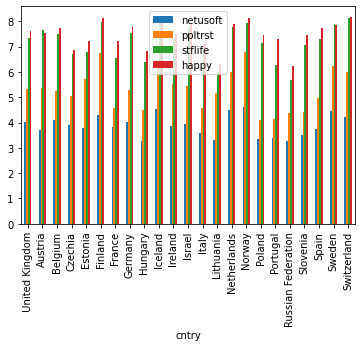

In [25]:
# Looking at different variables' average values depending on the country
survey.groupby(["cntry"]).mean()[["netusoft", "ppltrst", "stflife", "happy"]].plot(kind="bar")

In [31]:
# Checking correlation indexes between variables
survey.corr()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
gndr,1.000000,-0.031312,-0.011929,0.024119,0.000731,-0.047564,-0.024822,-0.012650,-0.008505,-0.017906,-0.060851,0.000899,0.057358,-0.038311,0.024880,0.054400
nwspol,-0.031312,1.000000,0.017213,0.049885,-0.040602,-0.080306,-0.005054,-0.036821,-0.013265,-0.024493,-0.021221,-0.029664,0.067684,-0.002699,-0.007679,0.025713
netustm,-0.011929,0.017213,1.000000,-0.062691,0.096201,0.036206,-0.003249,0.001622,-0.009209,-0.014659,-0.008607,0.007000,-0.039515,-0.020140,0.004006,0.027182
agea,0.024119,0.049885,-0.062691,1.000000,-0.065946,-0.189940,-0.012545,-0.022571,0.001900,-0.014513,-0.019765,-0.037777,0.121122,0.018040,-0.029229,-0.024778
eduyrs,0.000731,-0.040602,0.096201,-0.065946,1.000000,0.415440,0.175062,0.133409,0.031670,0.009785,0.007426,0.124741,-0.228515,-0.077833,0.167070,0.087707
netusoft,-0.047564,-0.080306,0.036206,-0.189940,0.415440,1.000000,0.158932,0.194914,0.031487,0.059720,0.080861,0.192820,-0.376642,-0.061200,0.172563,0.069311
ppltrst,-0.024822,-0.005054,-0.003249,-0.012545,0.175062,0.158932,1.000000,0.259085,0.234206,0.223187,0.225055,0.225215,-0.172671,0.002369,0.142425,0.002831
stflife,-0.012650,-0.036821,0.001622,-0.022571,0.133409,0.194914,0.259085,1.000000,0.261343,0.264523,0.291487,0.698305,-0.357234,-0.041835,0.148077,-0.013157
stfgov,-0.008505,-0.013265,-0.009209,0.001900,0.031670,0.031487,0.234206,0.261343,1.000000,0.369602,0.334722,0.203278,-0.104720,0.051176,0.070224,-0.046107
stfedu,-0.017906,-0.024493,-0.014659,-0.014513,0.009785,0.059720,0.223187,0.264523,0.369602,1.000000,0.463909,0.231912,-0.136661,0.019226,0.054668,-0.061754


<AxesSubplot:>

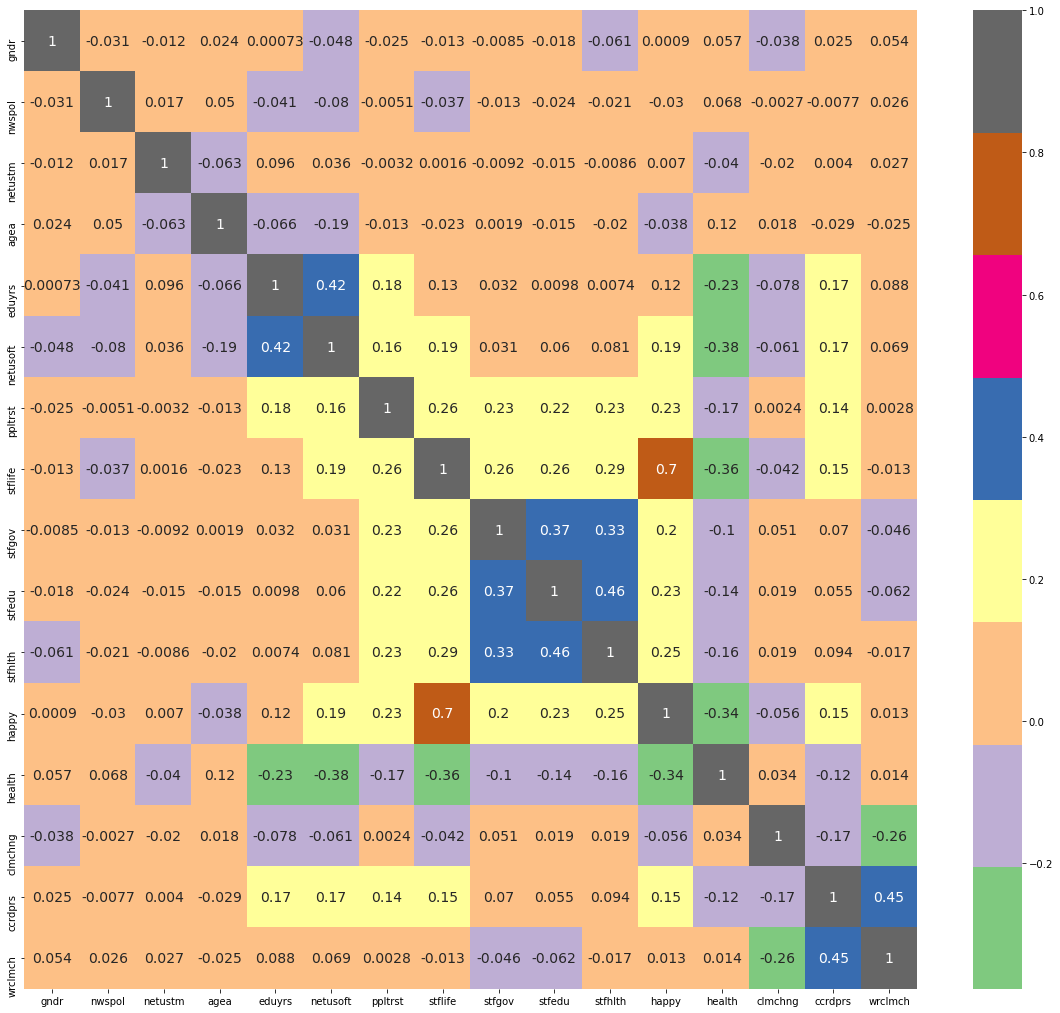

In [34]:
# Looking into variables correlation by drawing heat map
plt.figure(figsize=(20,18))
sns.heatmap(survey.corr(), annot = True, cmap="Accent", annot_kws={"size": 14})

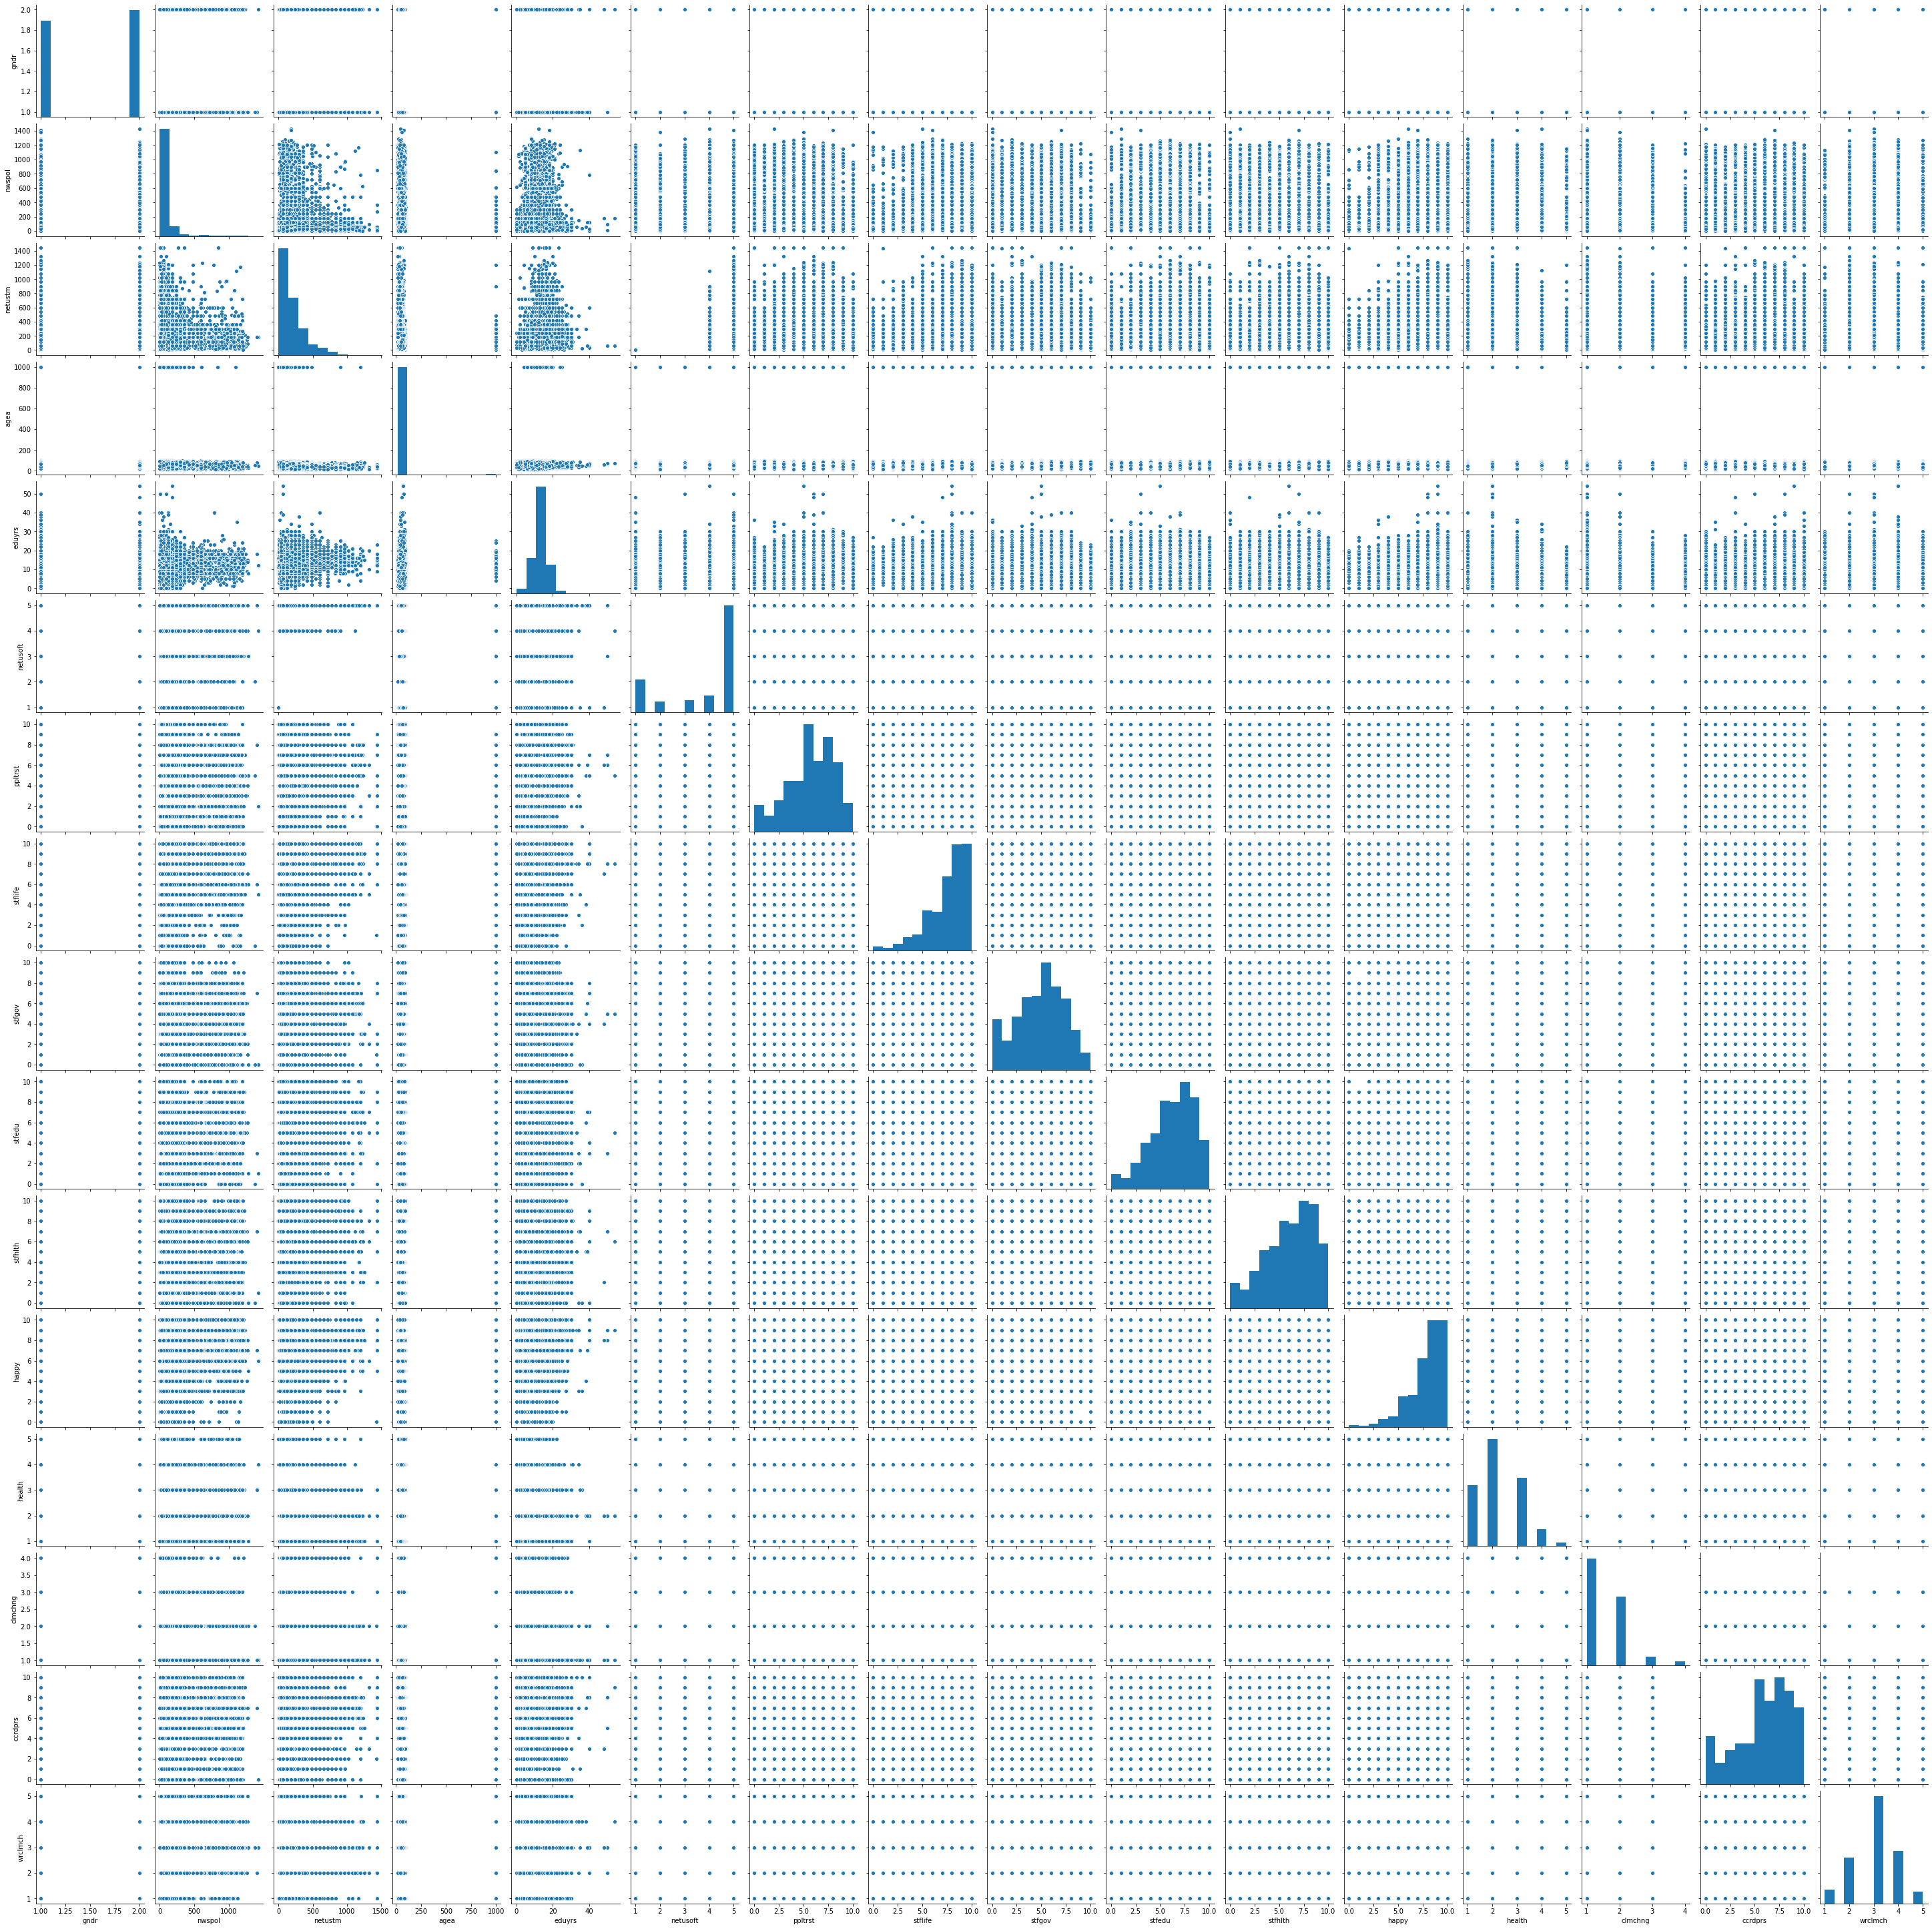

In [43]:
# Looking into the pair plots of variables to see if we can spot any visible correlation between variables
sns.pairplot(survey)

In [35]:
# Looking into relationship between Health and Satisfaction data
# stflife - All things considered, how satisfied are you with your life as a whole nowadays? Please answer using this card, where 0 means extremely dissatisfied and 10 means extremely satisfied.
# health - How is your health in general? (1 - very good, 5 - very bad)

<AxesSubplot:xlabel='cntry'>

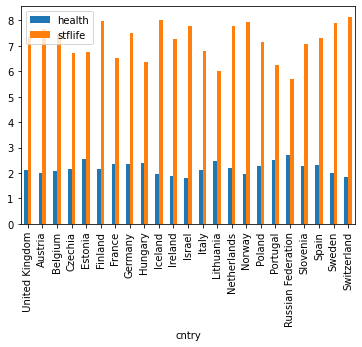

In [36]:
survey.groupby(["cntry"]).mean()[["health", "stflife"]].plot(kind="bar")

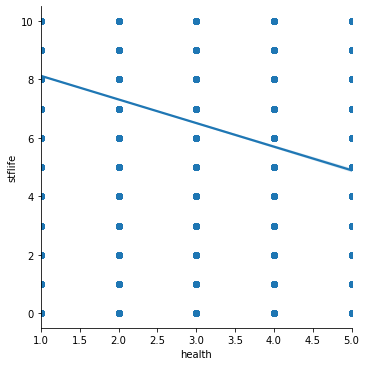

In [37]:
sns.lmplot(x="health", y="stflife", data=survey)

In [38]:
survey.groupby('cntry').mean().sort_values(by="health", ascending =True).head(10)[['health', 'stflife']]

,health,stflife
cntry,,
Israel,1.819711,7.789988
Switzerland,1.834098,8.148852
Ireland,1.871962,7.254625
Iceland,1.948513,8.022883
Norway,1.970874,7.936570
Austria,1.996020,7.659701
Sweden,1.999355,7.886452
Belgium,2.089468,7.480747
United Kingdom,2.112302,7.335886


In [39]:
# correlation coefficient between Health and Satisfaction in life is -0.159082
# By looking into OLS Regression model's results we can check if these two variables are significantly dependent
health_model = smf.ols(formula="stflife ~ health", data = survey).fit()
print(health_model.params)
print(health_model.summary())

Intercept    8.930254
health      -0.807712
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                stflife   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     6492.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:18:37   Log-Likelihood:                -92479.
No. Observations:               44378   AIC:                         1.850e+05
Df Residuals:                   44376   BIC:                         1.850e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### From the results above we can see that contructed regression model does not explain the relationship between these two variables very well as R-squared value is very small. Which means that only a small proportion of the data is explained by this model. Therefore, this model might not be the best solution to determine this relationship and make conclusions. 

In [40]:
# Looking into relationship between Happiness and Satisfaction data
# happy - How happy are you (0- Extremely unhappy, 10 Extremely happy)
# stflife - All things considered, how satisfied are you with your life as a whole nowadays? Please answer using this card, where 0 means extremely dissatisfied and 10 means extremely satisfied.

<AxesSubplot:xlabel='cntry'>

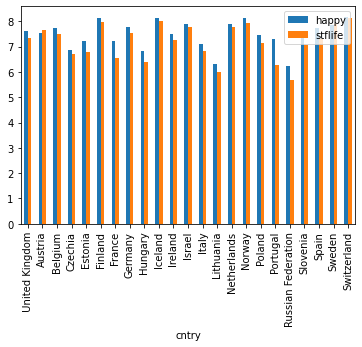

In [41]:
survey.groupby(["cntry"]).mean()[["happy", "stflife"]].plot(kind="bar")

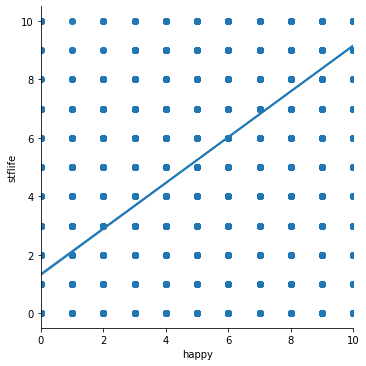

In [42]:
sns.lmplot(x="happy", y="stflife", data=survey)

In [43]:
# correlation coefficient between Happiness and Satisfaction is 0.702668
# By looking into OLS Regression model's results we can check if these two variables are significantly dependent

health_model = smf.ols(formula="stflife ~ happy", data = survey).fit()
print(health_model.params)
print(health_model.summary())

Intercept    1.328031
happy        0.783003
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                stflife   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                 4.223e+04
Date:                Thu, 01 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:22:39   Log-Likelihood:                -80671.
No. Observations:               44378   AIC:                         1.613e+05
Df Residuals:                   44376   BIC:                         1.614e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### From the results above we can see that contructed regression model does not explain the relationship between these two variables very well as R-squared value is quite small. This means that only 48.8% of the data is explained by this model.  So, this model might not be the best solution to determine this relationship. Therefore, we can try to optimise the data and check if this improves the result. 

### Optimising analysis by selecting data from Lithuanian respondends

In [44]:
# Extracting a data sample to have information only from Lithuanian respondents 
survey_LT = survey.query('cntry in "Lithuania"')

In [46]:
# Looking into statistical information of the selected data sample
survey_LT.describe()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
count,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000
mean,1.594251,82.441093,195.394910,57.520264,12.777097,3.327050,5.175778,6.002828,4.067861,5.144204,4.809614,6.320924,2.459001,1.696513,4.919416,2.887842
std,0.491152,81.783961,100.173826,86.588765,2.869269,1.678416,2.321967,2.122818,2.071589,2.071776,2.376322,2.089742,0.877433,0.821836,2.436678,0.862358
min,1.000000,0.000000,0.000000,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,30.000000,150.000000,36.000000,11.000000,1.000000,4.000000,5.000000,3.000000,4.000000,3.000000,5.000000,2.000000,1.000000,3.000000,2.000000
50%,2.000000,60.000000,197.000000,52.000000,13.000000,4.000000,5.000000,6.000000,4.000000,5.000000,5.000000,7.000000,2.000000,2.000000,5.000000,3.000000
75%,2.000000,110.000000,197.000000,66.000000,15.000000,5.000000,7.000000,7.000000,5.000000,7.000000,7.000000,8.000000,3.000000,2.000000,7.000000,3.000000
max,2.000000,780.000000,840.000000,999.000000,25.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,4.000000,10.000000,5.000000


In [47]:
# Checking correlation coefficients between variables in the selected data set
survey_LT.corr()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
gndr,1.000000,-0.038361,0.007858,0.048734,0.033148,-0.030547,0.004277,-0.044571,-0.073480,-0.033287,-0.054503,-0.013177,0.095399,-0.056419,0.033335,0.063930
nwspol,-0.038361,1.000000,-0.027421,0.084702,-0.092343,-0.307593,-0.025263,-0.101267,0.077846,0.064731,0.002769,-0.084173,0.264203,-0.011104,0.006441,0.035671
netustm,0.007858,-0.027421,1.000000,-0.043213,0.073287,0.022944,-0.039063,0.073464,-0.052505,-0.048681,-0.064335,0.079848,-0.027752,-0.003240,0.034684,-0.005371
agea,0.048734,0.084702,-0.043213,1.000000,-0.028562,-0.151044,-0.005274,-0.077209,0.019608,0.002304,0.004789,-0.055719,0.148316,0.005864,-0.018199,0.023127
eduyrs,0.033148,-0.092343,0.073287,-0.028562,1.000000,0.375519,0.089601,0.142686,0.033164,-0.026315,0.025650,0.164795,-0.241000,-0.066490,0.081387,0.036575
netusoft,-0.030547,-0.307593,0.022944,-0.151044,0.375519,1.000000,0.150739,0.373695,0.116195,0.017887,0.131583,0.307324,-0.552744,-0.020638,0.052791,-0.080837
ppltrst,0.004277,-0.025263,-0.039063,-0.005274,0.089601,0.150739,1.000000,0.296705,0.315681,0.229065,0.298896,0.234002,-0.178468,-0.008598,0.074253,-0.015579
stflife,-0.044571,-0.101267,0.073464,-0.077209,0.142686,0.373695,0.296705,1.000000,0.370481,0.288281,0.359193,0.672977,-0.391267,-0.037883,0.131844,0.003779
stfgov,-0.073480,0.077846,-0.052505,0.019608,0.033164,0.116195,0.315681,0.370481,1.000000,0.470198,0.526034,0.310258,-0.119860,-0.035806,0.132034,0.021681
stfedu,-0.033287,0.064731,-0.048681,0.002304,-0.026315,0.017887,0.229065,0.288281,0.470198,1.000000,0.634570,0.308489,-0.101528,-0.071755,0.080660,-0.033166


<AxesSubplot:>

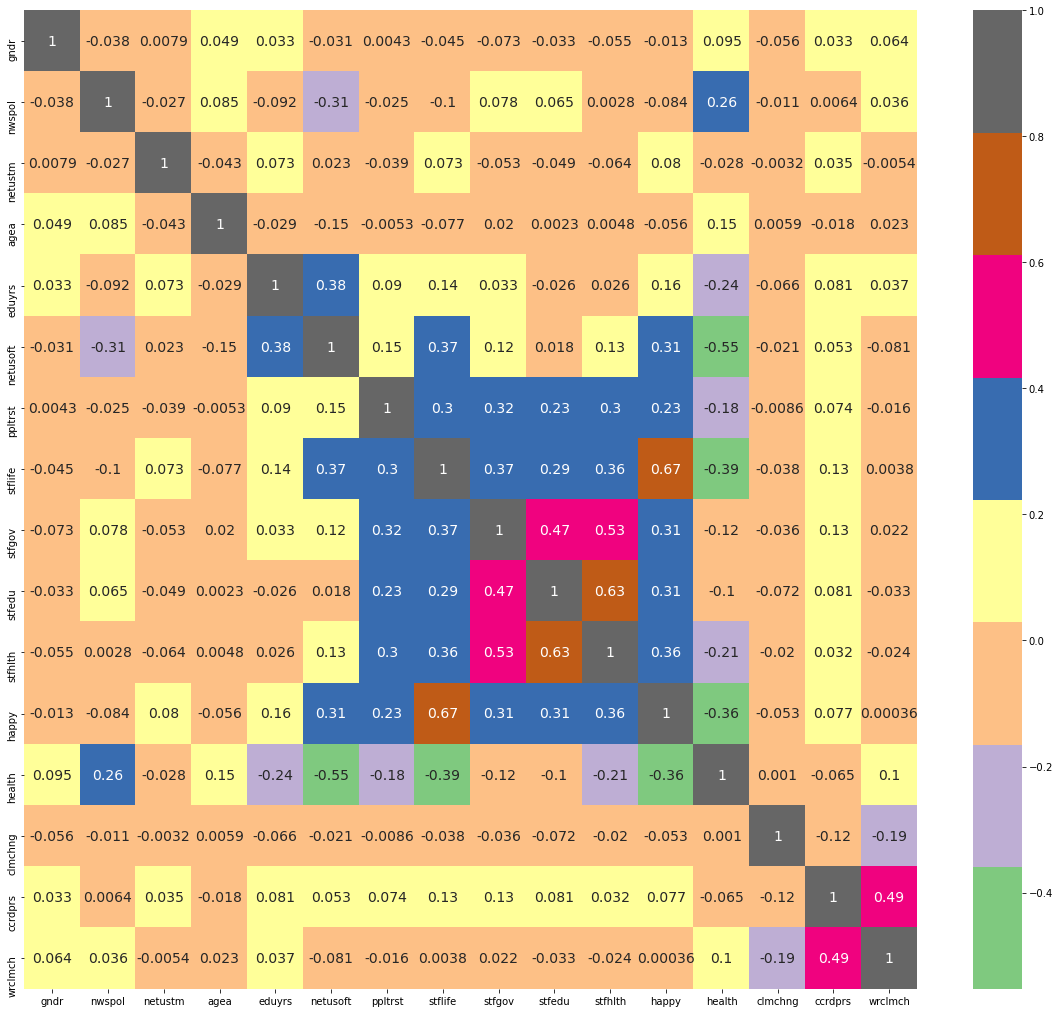

In [50]:
# Looking into the heat map to see if it is possible to spot any clear correlations between variables
plt.figure(figsize=(20,18))
sns.heatmap(survey_LT.corr(), annot = True, cmap="Accent", annot_kws={"size": 14})

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='health', ylabel='Density'>

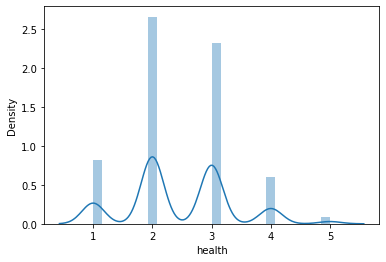

In [51]:
# Looking into "health" variable values' distribution
sns.distplot(survey_LT['health'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='stflife', ylabel='Density'>

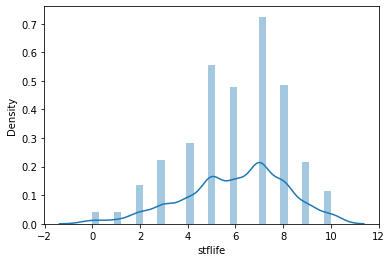

In [52]:
# Looking into "stflife" variable values' distribution
sns.distplot(survey_LT['stflife'])

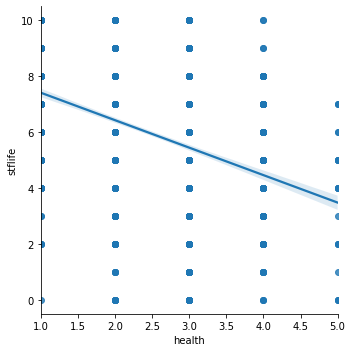

In [44]:
# Checking  correlation graph of variables "health" and "stflife"
sns.lmplot(x="health", y="stflife", data=survey_LT)

In [53]:
# correlation coefficient between Health and Satisfaction in life is -0.401485
# By looking into OLS Regression model's results we can check if these two variables are significantly dependent

LT_health_model = smf.ols(formula="stflife ~ health", data = survey_LT).fit()
print(LT_health_model.params)
print(LT_health_model.summary())

Intercept    8.330547
health      -0.946612
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                stflife   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     383.2
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.42e-78
Time:                        14:35:01   Log-Likelihood:                -4431.5
No. Observations:                2122   AIC:                             8867.
Df Residuals:                    2120   BIC:                             8878.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### As we can see from the results above even after the data optimisation contructed regression model does not explain the relationship between these two variables very well as R-squared value is still very small. Therefore, we cannot use this model to determine this relationship and make conclusions.

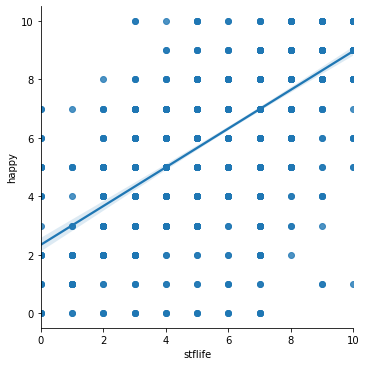

In [54]:
# Checking  correlation graph of variables "happy" and "stflife"
sns.lmplot(x="stflife", y="happy", data=survey_LT)

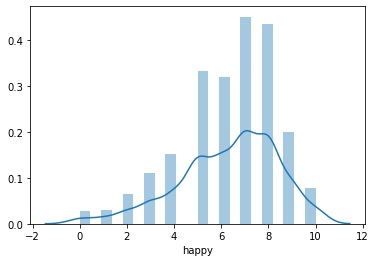

In [47]:
# Looking into distribution of variable's "happy" values
sns.distplot(survey_LT['happy'])

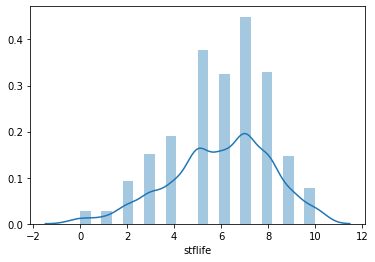

In [48]:
# Looking into distribution of variable's "stflife" values
sns.distplot(survey_LT['stflife'])

In [56]:
# correlation coefficient between Happiness and Satisfaction is 0.697514
# By looking into OLS Regression model's results we can check if these two variables are significantly dependent

LT_happiness_model = smf.ols(formula="happy ~ stflife", data = survey_LT).fit()
print(LT_happiness_model.params)
print(LT_happiness_model.summary())

Intercept    2.344107
stflife      0.662491
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     1755.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):          5.80e-280
Time:                        14:47:10   Log-Likelihood:                -3934.6
No. Observations:                2122   AIC:                             7873.
Df Residuals:                    2120   BIC:                             7884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### From the results above we can see after data optimisation contructed regression model still does not explain the relationship between these two variables very well as R-squared value is still quite small. However, by looking into other indicators we can see that p-values in this model are smaller than 0.05, therefore, model's coefficients are statisticaly significant. So, based on the model we can sae that when "Satisfaction" value increases by one, "Happiness" value increases by 0.6625. 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='standard_resid', ylabel='Density'>

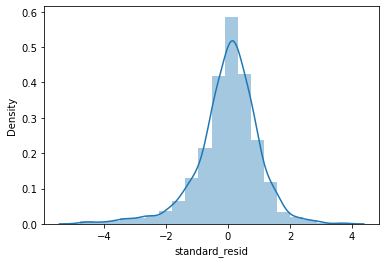

In [58]:
# Importing additional modules
from sklearn.model_selection import train_test_split
# Setting dependent and independent variables
x = survey_LT[['stflife']]
y = survey_LT['happy']

#Spliting data into two sets, for testing and training the model. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

# Assigning train set values for x and y
train_set = x_train.copy()
train_set['happy'] = y_train

# Testing model linear regression model:
est = smf.ols('happy ~ stflife', train_set).fit()

# Importing additional modules
from statsmodels.stats.outliers_influence import OLSInfluence
std_res = OLSInfluence(est).summary_frame()

# Looking into the standard residuals' distribution
sns.distplot(std_res["standard_resid"], bins=20)

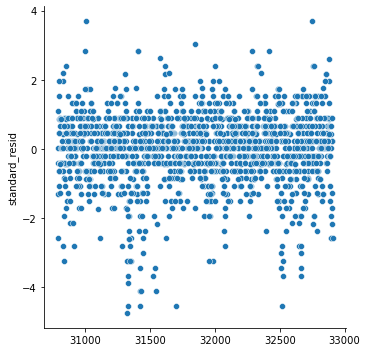

In [59]:
# Looking into the standard residuals' distribution
sns.relplot(data=std_res["standard_resid"])

In [60]:
# Looking into exclution in the data where standardised residuals are bigger than 3 standard deviations
std_res[np.abs(std_res['standard_resid']) > 3]

,dfb_Intercept,dfb_stflife,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
32523,-0.095211,0.072902,0.005742,-3.241840,0.001092,-0.107166,-3.250977,-0.107468
31003,0.148633,-0.125612,0.011868,3.698866,0.001732,0.154067,3.712790,0.154647
32747,0.148633,-0.125612,0.011868,3.698866,0.001732,0.154067,3.712790,0.154647
31982,0.009445,-0.038159,0.003809,-3.234564,0.000728,-0.087279,-3.243636,-0.087524
31323,0.116604,-0.165303,0.020151,-4.750847,0.001782,-0.200751,-4.781386,-0.202042
31422,0.013285,-0.053672,0.007490,-4.535905,0.000728,-0.122394,-4.562341,-0.123107
31700,0.013285,-0.053672,0.007490,-4.535905,0.000728,-0.122394,-4.562341,-0.123107
31329,0.013285,-0.053672,0.007490,-4.535905,0.000728,-0.122394,-4.562341,-0.123107
32660,-0.068383,0.040644,0.004797,-3.672770,0.000711,-0.097950,-3.686384,-0.098314
31327,-0.095211,0.072902,0.005742,-3.241840,0.001092,-0.107166,-3.250977,-0.107468


In [61]:
# Predicting values with the constructed model
pred = est.get_prediction(x_test)
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,7.634368,0.051572,7.533216,7.735520,4.617200,10.651536
1,5.644641,0.040988,5.564249,5.725034,2.628098,8.661185
2,6.971126,0.041470,6.889788,7.052464,3.954557,9.987695
3,3.654915,0.078871,3.500220,3.809610,0.635477,6.674352
4,5.644641,0.040988,5.564249,5.725034,2.628098,8.661185
...,...,...,...,...,...,...
420,6.971126,0.041470,6.889788,7.052464,3.954557,9.987695
421,6.971126,0.041470,6.889788,7.052464,3.954557,9.987695
422,4.981399,0.050796,4.881771,5.081028,1.964282,7.998517
423,6.971126,0.041470,6.889788,7.052464,3.954557,9.987695


##### In the table above we can see predicted intervals of the real values based on the provided data. 